In [2]:
import matplotlib.pyplot as plt
import numpy as np
from math import *
from scipy.optimize import curve_fit, minimize
from scipy.stats import poisson
from tqdm import tqdm
from glob import glob

In [3]:
countrateData = np.loadtxt("./../data/countRate_vs_threshold.txt", delimiter=",", skiprows=1)

countrateDictionary = {
    "threshold": countrateData[:,0],
    "counts": countrateData[:,1],
    "time": countrateData[:,2]
}

rates = []
for count, time in zip (countrateDictionary["counts"], countrateDictionary["time"]):
    rates.append(count / time)

countrateDictionary["rates"] = rates

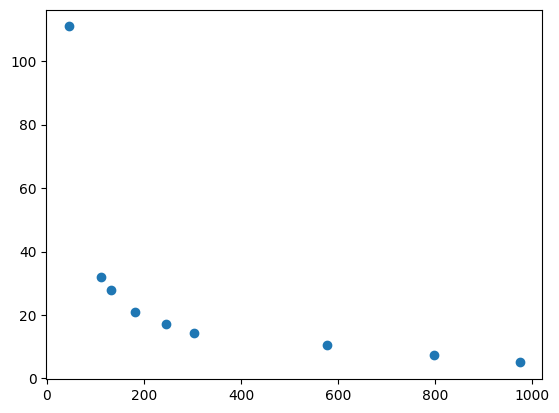

In [4]:
plt.scatter(countrateDictionary["threshold"], countrateDictionary["rates"])

In [165]:
def LoadExperimentRun(path, numberOfChannelsToRemove):

    binCounts = np.loadtxt(path)[numberOfChannelsToRemove[0]:-numberOfChannelsToRemove[1]]

    binNumber = np.arange(numberOfChannelsToRemove[0], len(binCounts))

    return (binNumber, binCounts)

def LoadMultipleRuns(basePath, filenamePrefix, numberOfChannelsToRemove):
    #print(basePath + filenamePrefix + "*.txt")
    filePaths = glob(basePath + filenamePrefix + "*.txt")
    
    filePaths.sort()
    print(f"Loading:\n{filePaths}")

    binsSample = LoadExperimentRun(filePaths[0], numberOfChannelsToRemove)[0]
    countsSample = LoadExperimentRun(filePaths[0], numberOfChannelsToRemove)[1]

    binCounts = np.zeros(np.shape(countsSample))
    for filePath in filePaths:
        binCounts = binCounts + LoadExperimentRun(filePath, numberOfChannelsToRemove)[1]
        
    return (binsSample, binCounts)

In [126]:
LoadMultipleRuns("../data/", "autoDetection_T-800mV_40ns_DMH_", (10, 15))

Loading:
['../data/autoDetection_T-800mV_40ns_DMH_4320s_001.txt', '../data/autoDetection_T-800mV_40ns_DMH_4320s_002.txt', '../data/autoDetection_T-800mV_40ns_DMH_4320s_003.txt', '../data/autoDetection_T-800mV_40ns_DMH_4320s_004.txt', '../data/autoDetection_T-800mV_40ns_DMH_4320s_005.txt', '../data/autoDetection_T-800mV_40ns_DMH_4320s_006.txt', '../data/autoDetection_T-800mV_40ns_DMH_4320s_007.txt', '../data/autoDetection_T-800mV_40ns_DMH_4320s_008.txt', '../data/autoDetection_T-800mV_40ns_DMH_75600s_000.txt']
21.0
48.0
59.0
75.0
82.0
90.0
100.0
109.0
298.0


(array([  10,   11,   12, ..., 4068, 4069, 4070]),
 array([298., 158., 134., ...,   0.,   0.,   0.]))

In [127]:
# Data Analysis pipeline

def RebinData(data, binFraction, method="mean", verbose=False):
    # Inputs are the data output from LoadExperimentRun, and a binFraction which is a number between 0 and 1 which determines how large the bins are

    bins = list(data[0])
    data = list(data[1])

    binWidth = len(data) * binFraction

    lowerBound = bins[0]
    numberOfBins = floor(len(data) / binWidth)

    newBins = np.arange(lowerBound, binWidth * (numberOfBins + 1), binWidth)
    newBins = [floor(el) for el in newBins]

    #topBound = floor(newBins[-1] + binWidth)
    #newBins.append(topBound)
    
    binnedData = []

    for i, binBound in enumerate(newBins):
        #print(f"{i}/{len(newBins)}")
        if i < len(newBins)-1:
            binnedData.append(list(data[newBins[i]:newBins[i+1]]))

    # binnedData is a an array which each row containing a bin
    binnedData = np.array(binnedData, dtype="object")

    averagedBinnedData = []
    binnedDataLowerUncertainty = []
    binnedDataUpperUncertainty = []
    for row in tqdm(binnedData):

        avg = AverageDataInBin(row, method, verbose=verbose)
        averagedBinnedData.append(avg[0])
        binnedDataLowerUncertainty.append(avg[1])
        binnedDataUpperUncertainty.append(avg[2])

    return (newBins[:-1], averagedBinnedData, binnedDataLowerUncertainty, binnedDataUpperUncertainty)
    


In [222]:
def AverageDataInBin(dataInBin, method="mean", verbose=False):

    if method == "mean":
        averagedRow = sum(dataInBin) / len(dataInBin)
        uncertainty = np.std(dataInBin)

        upperUncertainty = lowerUncertainty = uncertainty

    elif method == "MLE":
        
        # Finds the maximum likelihood for mu in a poisson distribution
        # To do this we can find the minimum of the negative log likelihood
        model = minimize(MLE_negativeLogLikelihood, np.max(dataInBin) / 2, args=dataInBin, method="Nelder-Mead")
        
        averagedRow = model.x
        lowerUncertainty, upperUncertainty = poisson.interval(0.68, averagedRow) # 1 sigma uncertainty
        
        if verbose:
            print(averagedRow, uncertainty)

    return averagedRow, lowerUncertainty, upperUncertainty


# Method of Maximum Likelihood Estimation - Calculate the likelihood of the pmf function of a given mu for each datapoint in the bin
def MLE_negativeLogLikelihood(lamda, data):

    logLikelihoods = []
    for el in data:
        logLikelihoods.append(poisson.pmf(k=el, mu = lamda))

    return -1 * np.sum(logLikelihoods)


def FindFitParameters(data, FittingFunction, sigma):

    if sigma != None:
        pars, cov = curve_fit(FittingFunction, data[0], data[1], [2, -0.001, 0.1, 0.1], sigma=sigma, absolute_sigma=False)

    else:
        pars, cov = curve_fit(FittingFunction, data[0], data[1], [2, -0.001, 0.1, 0.1])

    return pars, cov
    
def ExponentialCurve(x, a, b, c, d):
    y = []
    
    for point in x:
        y.append(a * exp(b * point + c) + d)
    
    return y

In [205]:
#data = LoadExperimentRun("./../data/autoDetection_T-800mV_40ns_DMH_75600s_000.txt", 90)

data = LoadMultipleRuns("../data/", "autoDetection_T-800mV_40ns_DMH_", (90, 20))

binFraction = 0.05
binSize = int(binFraction * data[0][-1])
print(f"Bin Size: {binSize} channels")

rebinnedData = RebinData(data, binFraction, method="mean", verbose=False)

x = rebinnedData[0]
y = rebinnedData[1]
y = np.squeeze(y)

yErr = np.array(list(zip(rebinnedData[2], rebinnedData[3]))).T
yErr = np.squeeze(yErr)

Loading:
['../data/autoDetection_T-800mV_40ns_DMH_4320s_001.txt', '../data/autoDetection_T-800mV_40ns_DMH_4320s_002.txt', '../data/autoDetection_T-800mV_40ns_DMH_4320s_003.txt', '../data/autoDetection_T-800mV_40ns_DMH_4320s_004.txt', '../data/autoDetection_T-800mV_40ns_DMH_4320s_005.txt', '../data/autoDetection_T-800mV_40ns_DMH_4320s_006.txt', '../data/autoDetection_T-800mV_40ns_DMH_4320s_007.txt', '../data/autoDetection_T-800mV_40ns_DMH_4320s_008.txt', '../data/autoDetection_T-800mV_40ns_DMH_4320s_009.txt', '../data/autoDetection_T-800mV_40ns_DMH_4320s_010.txt', '../data/autoDetection_T-800mV_40ns_DMH_4320s_011.txt', '../data/autoDetection_T-800mV_40ns_DMH_4320s_012.txt', '../data/autoDetection_T-800mV_40ns_DMH_4320s_013.txt', '../data/autoDetection_T-800mV_40ns_DMH_4320s_014.txt', '../data/autoDetection_T-800mV_40ns_DMH_4320s_015.txt', '../data/autoDetection_T-800mV_40ns_DMH_4320s_016.txt', '../data/autoDetection_T-800mV_40ns_DMH_4320s_017.txt', '../data/autoDetection_T-800mV_40ns_DM

100%|██████████| 20/20 [00:00<00:00, 8323.68it/s]


Text(0.5, 1.0, 'Mean and Stanard Deviation Method\nBin Size: 199')

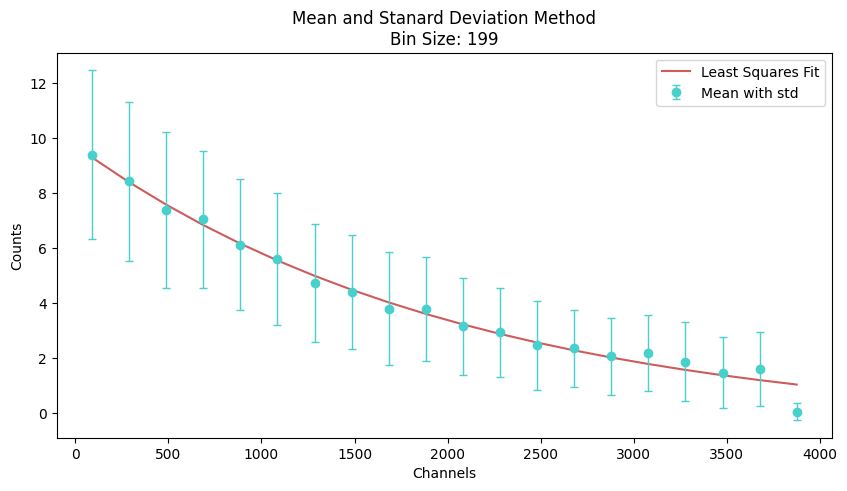

In [187]:
pars, cov = FindFitParameters(rebinnedData[0:2], ExponentialCurve, sigma=None)


fig, ax = plt.subplots(1, 1, figsize=(10,5))

ax.plot(rebinnedData[0], ExponentialCurve(rebinnedData[0], pars[0], pars[1], pars[2], pars[3]), color="indianred", label="Least Squares Fit")

ax.errorbar(x, y, yerr=yErr, fmt="o", capsize=3, linewidth=1, color="mediumturquoise", label="Mean with std")
ax.set_xlabel("Channels")
ax.set_ylabel("Counts")
ax.legend()
ax.set_title(f"Mean and Stanard Deviation Method\nBin Size: {binSize}")

In [228]:
#data = LoadExperimentRun("./../data/muons_T-800mV_W-40ns_DMH_75600s.txt", 90)

data = LoadMultipleRuns("../data/", "autoDetection_T-800mV_40ns_DMH_", (90, 100))

rebinnedData = RebinData(data, 0.05, method="MLE", verbose=False)

x = rebinnedData[0]
y = rebinnedData[1]
y = np.squeeze(y)

yErr = np.array(list(zip(rebinnedData[2], rebinnedData[3]))).T
yErr = np.squeeze(yErr)

Loading:
['../data/autoDetection_T-800mV_40ns_DMH_4320s_001.txt', '../data/autoDetection_T-800mV_40ns_DMH_4320s_002.txt', '../data/autoDetection_T-800mV_40ns_DMH_4320s_003.txt', '../data/autoDetection_T-800mV_40ns_DMH_4320s_004.txt', '../data/autoDetection_T-800mV_40ns_DMH_4320s_005.txt', '../data/autoDetection_T-800mV_40ns_DMH_4320s_006.txt', '../data/autoDetection_T-800mV_40ns_DMH_4320s_007.txt', '../data/autoDetection_T-800mV_40ns_DMH_4320s_008.txt', '../data/autoDetection_T-800mV_40ns_DMH_4320s_009.txt', '../data/autoDetection_T-800mV_40ns_DMH_4320s_010.txt', '../data/autoDetection_T-800mV_40ns_DMH_4320s_011.txt', '../data/autoDetection_T-800mV_40ns_DMH_4320s_012.txt', '../data/autoDetection_T-800mV_40ns_DMH_4320s_013.txt', '../data/autoDetection_T-800mV_40ns_DMH_4320s_014.txt', '../data/autoDetection_T-800mV_40ns_DMH_4320s_015.txt', '../data/autoDetection_T-800mV_40ns_DMH_4320s_016.txt', '../data/autoDetection_T-800mV_40ns_DMH_4320s_017.txt', '../data/autoDetection_T-800mV_40ns_DM

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [00:10<00:00,  1.89it/s]


Text(0.5, 1.0, 'Maximum Likelihood Estimation Method (Poisson)\nBin Size: 199')

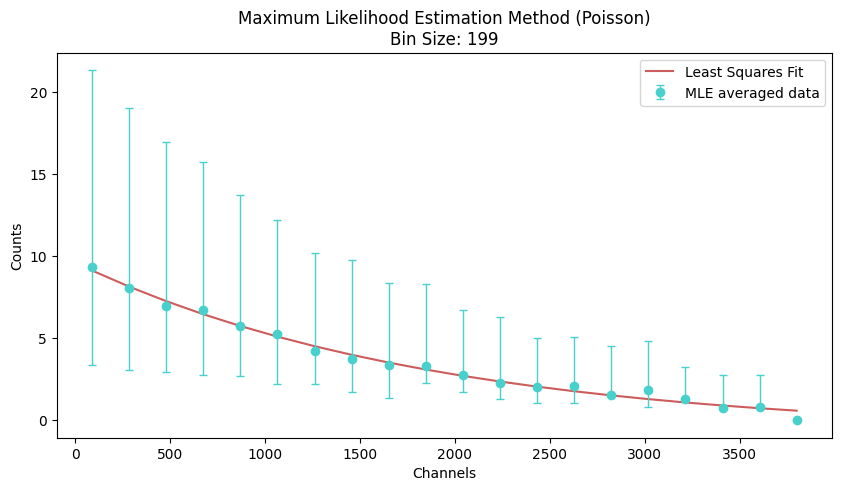

In [236]:
pars, cov = FindFitParameters((x, y), ExponentialCurve, sigma=None)


fig, ax = plt.subplots(1, 1, figsize=(10,5))

ax.plot(rebinnedData[0], ExponentialCurve(rebinnedData[0], pars[0], pars[1], pars[2], pars[3]), color="indianred", label="Least Squares Fit")

ax.errorbar(x, y, yerr=yErr, fmt="o", capsize=3, linewidth=1, color="mediumturquoise", label="MLE averaged data")
ax.set_xlabel("Channels")
ax.set_ylabel("Counts")
ax.legend()
ax.set_title(f"Maximum Likelihood Estimation Method (Poisson)\nBin Size: {binSize}")